In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

In [2]:
past_loans = pd.read_csv("data/PastLoans.csv")
past_loans.drop(["digital1", "digital2"], axis=1, inplace=True)

def preprocess(past_loans):
    # Define income bins and labels
    income_bins = [-1, 5000,20000,50000,1000000]
    income_labels = [0, 1, 2, 3]

    # Create a new column with income groups
    past_loans['income_group'] = pd.cut(past_loans['income'], bins=income_bins, labels=income_labels)
    past_loans.head()
    past_loans_encoded = past_loans.copy()
    past_loans_encoded['income_group'] = past_loans_encoded['income_group'].astype(float)

    # Encode dummy variable
    le = LabelEncoder()
    le.fit(past_loans["employment"])
    employement = le.transform(past_loans["employment"])
    past_loans_encoded["employment"] = employement

    # Min max income
    mm = MinMaxScaler()
    mm.fit(past_loans["income"].array.reshape(-1, 1))
    income = mm.transform(past_loans["income"].array.reshape(-1, 1))
    past_loans_encoded["income"] = income
    return past_loans_encoded
past_loans_encoded = preprocess(past_loans)

# EDA

<AxesSubplot: >

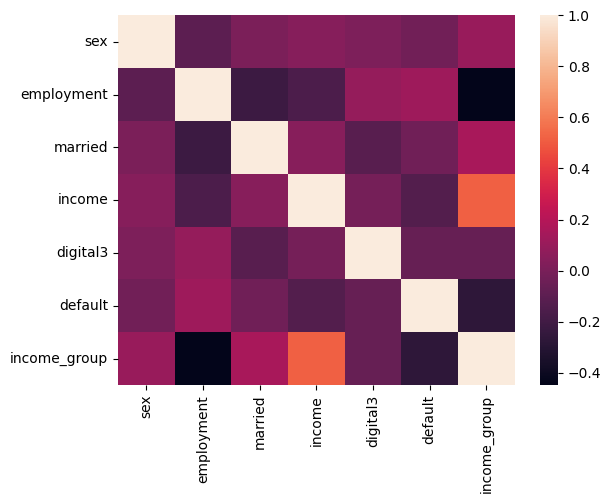

In [3]:
sns.heatmap(past_loans_encoded.corr())

In [4]:
Counter(past_loans_encoded["default"])

Counter({0: 77508, 1: 22492})

# Sampling

In [5]:
no_default = past_loans_encoded[past_loans_encoded["default"]==0]#[:22492]
default = past_loans_encoded[past_loans_encoded["default"]==1]
#add_to_test = past_loans_encoded[past_loans_encoded["default"]==0][22492:]

df = pd.concat([no_default, default])
df

,sex,employment,married,income,digital3,default,income_group
0,1,0,1,0.033610,0.167038,0,2.0
2,1,0,1,0.008504,0.066207,0,1.0
3,1,0,1,0.018460,0.625448,0,1.0
5,0,2,0,0.000000,0.764209,0,0.0
8,0,0,0,0.009034,0.000000,0,1.0
...,...,...,...,...,...,...,...
99986,1,0,1,0.008252,0.000000,1,1.0
99990,0,2,1,0.004627,0.334288,1,0.0
99993,0,0,1,0.015783,0.697369,1,1.0
99995,0,1,1,0.024785,0.000000,1,2.0


# Model

In [6]:
X = df.drop("default", axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = XGBClassifier(tree_method="hist", device="cuda", eval_metric="auc", objective="binary:logistic", verbosity = 0)
#model = LogisticRegression


model.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
importance = mutual_info_classif(X, y)
for i, l in zip(importance, model.feature_names_in_):
    print(i, l)

0.009841989374560711 sex
0.008879670896354552 employment
0.011794715766123565 married
0.05320887452667855 income
0.003959665614419627 digital3
0.04780510366786772 income_group


In [7]:
for i, l in zip(model.feature_importances_, model.feature_names_in_):
    print(i, l)

0.07251371 sex
0.2183645 employment
0.07555226 married
0.46602827 income
0.13456617 digital3
0.032975093 income_group


# Test Data

In [8]:
results = model.predict(X_test)
probabilities = model.predict_proba(X_test).T[1]
X_test_predict = X_test.copy()
X_test_predict["default"] = y_test
X_test_predict["prediction"] = results
X_test_predict["probability"] = probabilities
X_test_predict[:50]

model.score(X_test, y_test)

0.77124

In [9]:
f1_score(y_test, results)

0.18752663730643557

In [10]:
Counter(X_test_predict["prediction"])

Counter({0: 23681, 1: 1319})

In [11]:
tn, fp, fn, tp = confusion_matrix(y_test, results).ravel()
error_rate = fn/(fn+tn)
#confusion_matrix(y_test, results)

# Output

In [12]:
inference = pd.read_csv("data/NewApplications_Lender3.csv", index_col="id")
inference.head()
df_inference = preprocess(inference) 
df_inference

,sex,employment,married,income,digital3,income_group
id,,,,,,
1,1,3,1,0.016514,0.000000,1.0
2,0,0,1,0.008842,0.000000,1.0
3,0,0,0,0.019424,0.596771,1.0
4,1,3,1,0.007418,0.622311,1.0
5,1,1,0,0.000843,0.388930,0.0
...,...,...,...,...,...,...
99996,1,2,0,0.000000,0.933285,0.0
99997,1,0,1,0.018066,0.567901,1.0
99998,1,0,0,0.007273,0.669176,1.0


In [13]:
inference_results = model.predict(df_inference)
inference_proba = model.predict_proba(df_inference).T[1]
df_results = df_inference.copy()
df_results["results"] = inference_results
df_results["prob"] = inference_proba
df_results

,sex,employment,married,income,digital3,income_group,results,prob
id,,,,,,,,
1,1,3,1,0.016514,0.000000,1.0,0,0.080525
2,0,0,1,0.008842,0.000000,1.0,0,0.260548
3,0,0,0,0.019424,0.596771,1.0,0,0.055157
4,1,3,1,0.007418,0.622311,1.0,0,0.210707
5,1,1,0,0.000843,0.388930,0.0,0,0.464445
...,...,...,...,...,...,...,...,...
99996,1,2,0,0.000000,0.933285,0.0,0,0.313893
99997,1,0,1,0.018066,0.567901,1.0,0,0.133647
99998,1,0,0,0.007273,0.669176,1.0,0,0.236708


In [14]:
Counter(df_results["results"])

Counter({0: 95009, 1: 4991})

In [15]:
df_results["r"] = df_results["prob"]/(1-df_results["prob"])
df_results

,sex,employment,married,income,digital3,income_group,results,prob,r
id,,,,,,,,,
1,1,3,1,0.016514,0.000000,1.0,0,0.080525,0.087577
2,0,0,1,0.008842,0.000000,1.0,0,0.260548,0.352353
3,0,0,0,0.019424,0.596771,1.0,0,0.055157,0.058377
4,1,3,1,0.007418,0.622311,1.0,0,0.210707,0.266956
5,1,1,0,0.000843,0.388930,0.0,0,0.464445,0.867220
...,...,...,...,...,...,...,...,...,...
99996,1,2,0,0.000000,0.933285,0.0,0,0.313893,0.457498
99997,1,0,1,0.018066,0.567901,1.0,0,0.133647,0.154264
99998,1,0,0,0.007273,0.669176,1.0,0,0.236708,0.310114


In [16]:
threshold = 0.5 # threshold of interest rates to keep

interest_rate_target = error_rate/(1-error_rate)
avg_r = np.mean(df_results[df_results["r"]<threshold]["r"])
increase = interest_rate_target - avg_r

markup = 0.1 # percentage over the interest rate to markup
df_results["final_r"] = (df_results["r"] + increase)#*(1 + markup)
df_results

# Put final_r to nan if r > threshold
df_results_del = df_results.copy()
df_results_del["final_r"] = df_results["final_r"].where(df_results["r"]<threshold, "")
df_results_del

,sex,employment,married,income,digital3,income_group,results,prob,r,final_r
id,,,,,,,,,,
1,1,3,1,0.016514,0.000000,1.0,0,0.080525,0.087577,0.159222
2,0,0,1,0.008842,0.000000,1.0,0,0.260548,0.352353,0.423998
3,0,0,0,0.019424,0.596771,1.0,0,0.055157,0.058377,0.130021
4,1,3,1,0.007418,0.622311,1.0,0,0.210707,0.266956,0.338601
5,1,1,0,0.000843,0.388930,0.0,0,0.464445,0.867220,
...,...,...,...,...,...,...,...,...,...,...
99996,1,2,0,0.000000,0.933285,0.0,0,0.313893,0.457498,0.529143
99997,1,0,1,0.018066,0.567901,1.0,0,0.133647,0.154264,0.225908
99998,1,0,0,0.007273,0.669176,1.0,0,0.236708,0.310114,0.381759


In [17]:
# Actual Output dataframe
final = df_results_del[["final_r"]].reset_index()
final.rename(columns={"final_r" : "rate"}, inplace=True)

# Export

In [18]:
final.to_csv("output.csv", index=False) 